In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

import gensim.downloader as api
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
glove_model = api.load("glove-wiki-gigaword-50")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

In [3]:
resume_file_path = 'Resume-cleaned.csv'

job_file_path = 'Job-postings-10k.csv'

# Loading the datasets
df_resumes = pd.read_csv(resume_file_path)
df_jobs = pd.read_csv(job_file_path)

# Displaying the first few rows to verify
print(df_resumes.head())
print(df_jobs.head())


Mounted at /content/drive
         ID                                         Resume_str Category
0  16852973  HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADM...       HR
1  22323967  HR SPECIALIST, US HR OPERATIONS       Summary ...       HR
2  33176873  HR DIRECTOR       Summary      Over 20 years e...       HR
3  11592605  HR GENERALIST       Summary     Dedicated and ...       HR
4  25824789  HR MANAGER       Summary    HUMAN RESOURCES MA...       HR
       job_id           company_name                                title  \
0  3902861999           AMC Networks                   Supv - Origination   
1  3886837949              Food Lion           PT Customer Service Leader   
2  3904005637  Holiday Stationstores           Store Assistant, Full Time   
3  3904360984        Google DeepMind  Technical Program Manager, Robotics   
4  3902737098                Lovesac           Assistant Showroom Manager   

                                         description            location  \
0  

In [4]:
if 'location' in df_jobs.columns:
    df_jobs = df_jobs.drop(columns=['location'])

In [5]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])

df_resumes['clean_str'] = df_resumes['Resume_str'].fillna('').apply(preprocess_text)
df_jobs['clean_str'] = df_jobs['description'].fillna('').apply(preprocess_text)


In [ ]:
import pandas as pd

#count of distinct values in the 'category' column
distinct_count = df_resumes['Category'].nunique()

print(f"Number of distinct values in 'category': {distinct_count}")

Number of distinct values in 'category': 24


# ***TF-IDF***

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)

# vectorize job descriptions and resumes
tfidf_jobs = tfidf_vectorizer.fit_transform(df_jobs['clean_str'])
tfidf_resumes = tfidf_vectorizer.transform(df_resumes['clean_str'])

# cosine similarity between resumes and jobs
cosine_sim_tfidf = cosine_similarity(tfidf_resumes, tfidf_jobs)

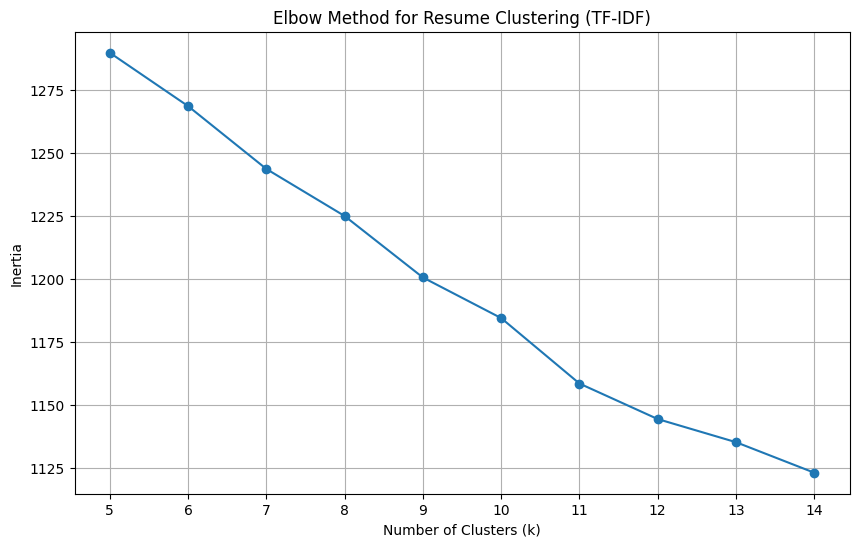

In [25]:
inertia = []
k_range = range(5, 15)

#using the TF-IDF resume matrix
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(tfidf_resumes)
    inertia.append(kmeans.inertia_)

#elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Resume Clustering (TF-IDF)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [26]:
kmeans_model = KMeans(n_clusters=10, random_state=42, n_init='auto')
resume_clusters = kmeans_model.fit_predict(tfidf_resumes)

df_resumes['Cluster'] = resume_clusters

#preview
cluster_counts = df_resumes['Cluster'].value_counts().sort_index()
print("Number of resumes in each cluster:")
print(cluster_counts)


Number of resumes in each cluster:
Cluster
0    175
1    215
2    308
3    180
4    371
5    225
6    214
7     73
8    107
9    117
Name: count, dtype: int64


In [27]:
# Count of resumes in each original category
category_counts = df_resumes['Category'].value_counts().sort_index()

# Display the counts
print("Number of resumes in each original category:")
print(category_counts)


Number of resumes in each original category:
Category
ACCOUNTANT                102
ADVOCATE                  103
AGRICULTURE                50
APPAREL                    77
ARTS                       80
AUTOMOBILE                 30
AVIATION                   92
BANKING                    98
BPO                        18
BUSINESS-DEVELOPMENT      104
CHEF                       90
CONSTRUCTION               83
CONSULTANT                 86
DESIGNER                   73
DIGITAL-MEDIA              71
ENGINEERING                98
FINANCE                   102
FITNESS                    93
HEALTHCARE                 97
HR                         95
INFORMATION-TECHNOLOGY     93
PUBLIC-RELATIONS           92
SALES                      81
TEACHER                    77
Name: count, dtype: int64


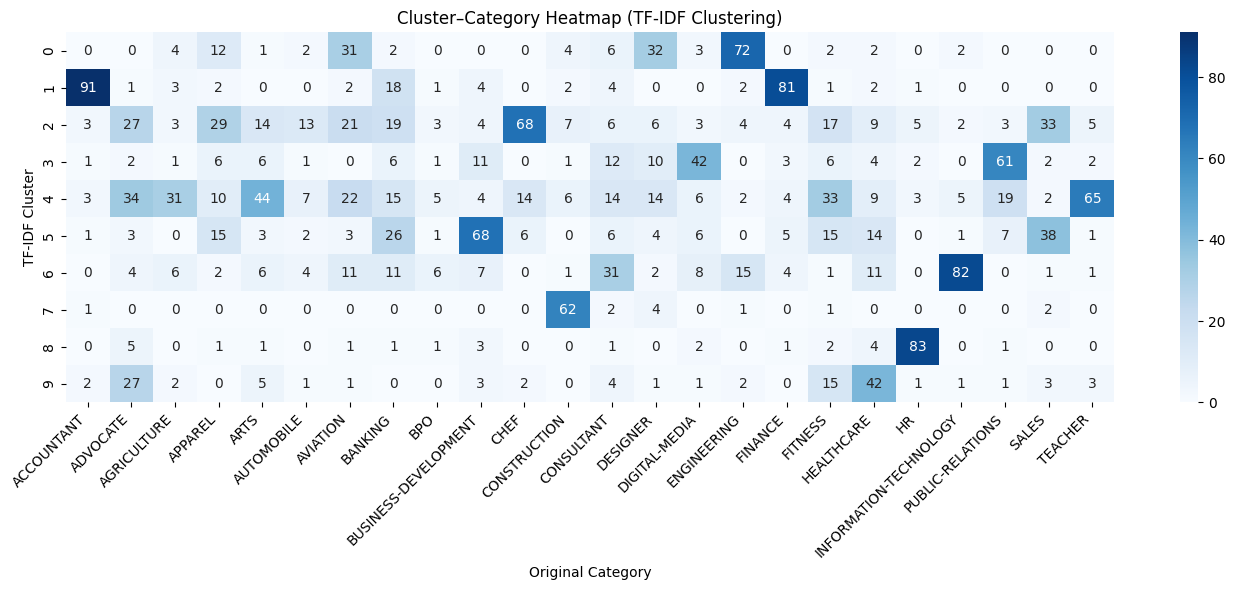

In [28]:
heatmap_data = pd.crosstab(df_resumes['Cluster'], df_resumes['Category'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')
plt.title('Cluster–Category Heatmap (TF-IDF Clustering)')
plt.xlabel('Original Category')
plt.ylabel('TF-IDF Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Good alignment with some categories, but most clusters seem ambiguous and group unrelated resumes together

TruncatedSVD is preferred over PCA for sparse TF-IDF data because it preserves structure without converting to dense format, making it faster and more memory-efficient.

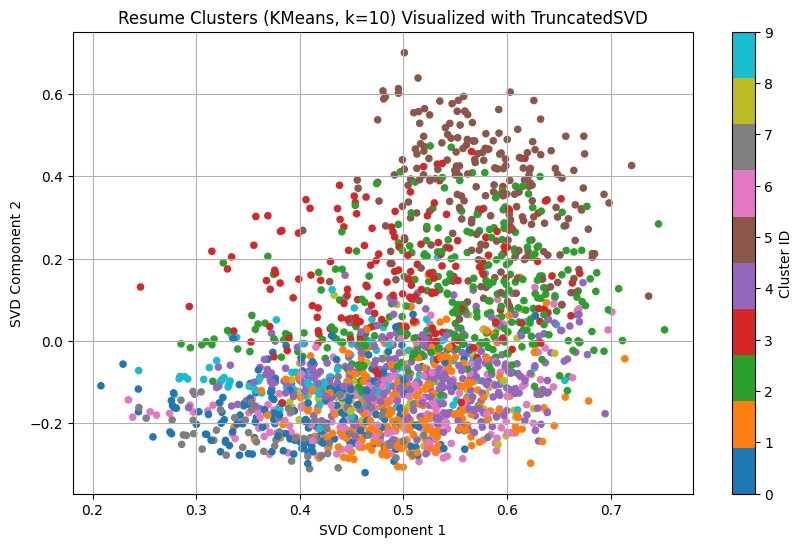

In [29]:
# SVD (mostly zeros, so SVD over PCA)
svd_full = TruncatedSVD(n_components=2, random_state=42)
resume_2d_full = svd_full.fit_transform(tfidf_resumes)

# K-Means cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(resume_2d_full[:, 0], resume_2d_full[:, 1], c=df_resumes['Cluster'], cmap='tab10', s=20)
plt.title('Resume Clusters (KMeans, k=10) Visualized with TruncatedSVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


In [30]:
# 5 most similar jobs for each resume and averaging their cosine similarity scores
def top_k_avg(sim_matrix, k=5):
    return np.mean([np.mean(np.sort(row)[-k:]) for row in sim_matrix])

avg_score = top_k_avg(cosine_sim_tfidf, k=5)
print(f"Average Top-5 Similarity Score (TF-IDF): {avg_score:.4f}")


Average Top-5 Similarity Score (TF-IDF): 0.5436


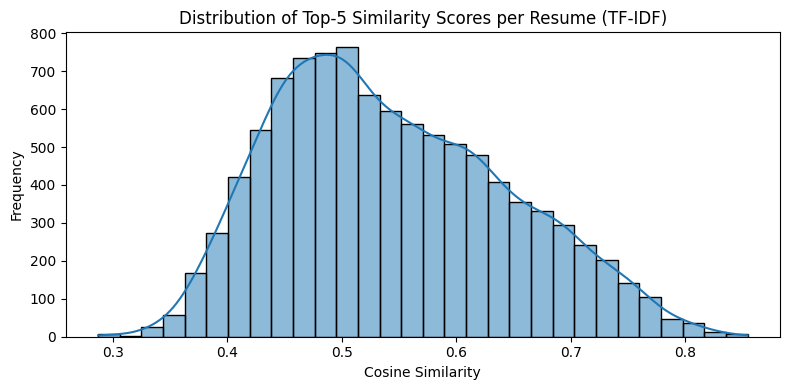

In [31]:
top_k = 5
top_scores = []

for row in cosine_sim_tfidf:
    top_k_scores = np.sort(row)[-top_k:]
    top_scores.extend(top_k_scores)

# Plot distribution of top-k scores
plt.figure(figsize=(8, 4))
sns.histplot(top_scores, bins=30, kde=True)
plt.title(f"Distribution of Top-{top_k} Similarity Scores per Resume (TF-IDF)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [32]:
X_dense = tfidf_jobs.toarray()

# tring a few cluster counts
gmm_scores = []
for k in [5, 10, 15]:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_dense)

    if len(set(labels)) > 1:
        score = silhouette_score(X_dense, labels)
        gmm_scores.append({'n_clusters': k, 'silhouette_score': score})

gmm_df = pd.DataFrame(gmm_scores)
print("\nGMM Silhouette Scores (TF-IDF Job Descriptions):")
print(gmm_df.sort_values(by='silhouette_score', ascending=False))



GMM Silhouette Scores (TF-IDF Job Descriptions):
   n_clusters  silhouette_score
2          15          0.031482
1          10          0.029818
0           5          0.025459


The low silhouette scores show that TF-IDF doesn't group similar job descriptions very clearly. It captures basic word patterns but not enough meaning to form strong clusters.

# ***Word2Vec***

In [33]:
# tokenizing resumes and jobs
df_resumes['tokens'] = df_resumes['clean_str'].apply(lambda x: x.split())
df_jobs['tokens'] = df_jobs['clean_str'].apply(lambda x: x.split())

# combine all tokens for Word2Vec training
all_tokens = df_resumes['tokens'].tolist() + df_jobs['tokens'].tolist()

w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    epochs=10
)

# average word vectors
def average_w2v_vector(tokens, model):
    valid_words = [w for w in tokens if w in model.wv]
    return np.mean([model.wv[w] for w in valid_words], axis=0) if valid_words else np.zeros(model.vector_size)

# compute document vectors for resumes and jobs
resume_vecs = np.vstack(df_resumes['tokens'].apply(lambda x: average_w2v_vector(x, w2v_model)))
job_vecs = np.vstack(df_jobs['tokens'].apply(lambda x: average_w2v_vector(x, w2v_model)))

# cosine similarity between resumes and jobs
cosine_sim_w2v = cosine_similarity(resume_vecs, job_vecs)

Average Top-5 Similarity Score (Word2Vec): 0.9594


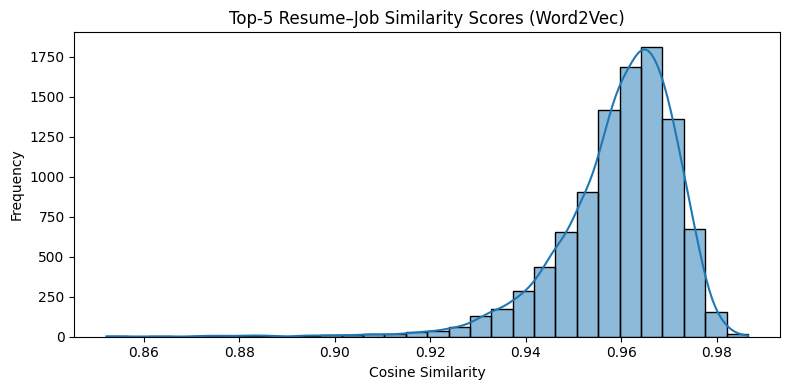

In [34]:
# average of top-k similarity scores
avg_score_w2v = top_k_avg(cosine_sim_w2v, k=5)
print(f"Average Top-5 Similarity Score (Word2Vec): {avg_score_w2v:.4f}")

# distribution of top-k scores
top_k = 5
top_scores = []
for row in cosine_sim_w2v:
    top_scores.extend(np.sort(row)[-top_k:])

plt.figure(figsize=(8, 4))
sns.histplot(top_scores, bins=30, kde=True)
plt.title("Top-5 Resume–Job Similarity Scores (Word2Vec)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

 the score shows that Word2vec captures strong semantic relationships between resumes and job descriptions

In [35]:
# KMeans clustering on Word2Vec resume vectors
kmeans_w2v = KMeans(n_clusters=10, random_state=42)
w2v_labels = kmeans_w2v.fit_predict(resume_vecs)
df_resumes['W2V_Cluster'] = w2v_labels

# silhouette score
w2v_silhouette = silhouette_score(resume_vecs, w2v_labels)
print(f"Silhouette Score (Word2Vec Resumes): {w2v_silhouette:.4f}")

Silhouette Score (Word2Vec Resumes): 0.1371


In [36]:
# gmm on multiple clusters
gmm_scores = []
for k in [5, 10, 15]:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(resume_vecs)

    score = silhouette_score(resume_vecs, gmm_labels)
    gmm_scores.append({'n_clusters': k, 'silhouette_score': score})

# results
gmm_df = pd.DataFrame(gmm_scores)
print("\nGMM Silhouette Scores (Word2Vec Resumes):")
print(gmm_df.sort_values(by='silhouette_score', ascending=False))


GMM Silhouette Scores (Word2Vec Resumes):
   n_clusters  silhouette_score
1          10          0.136471
2          15          0.123193
0           5          0.123172


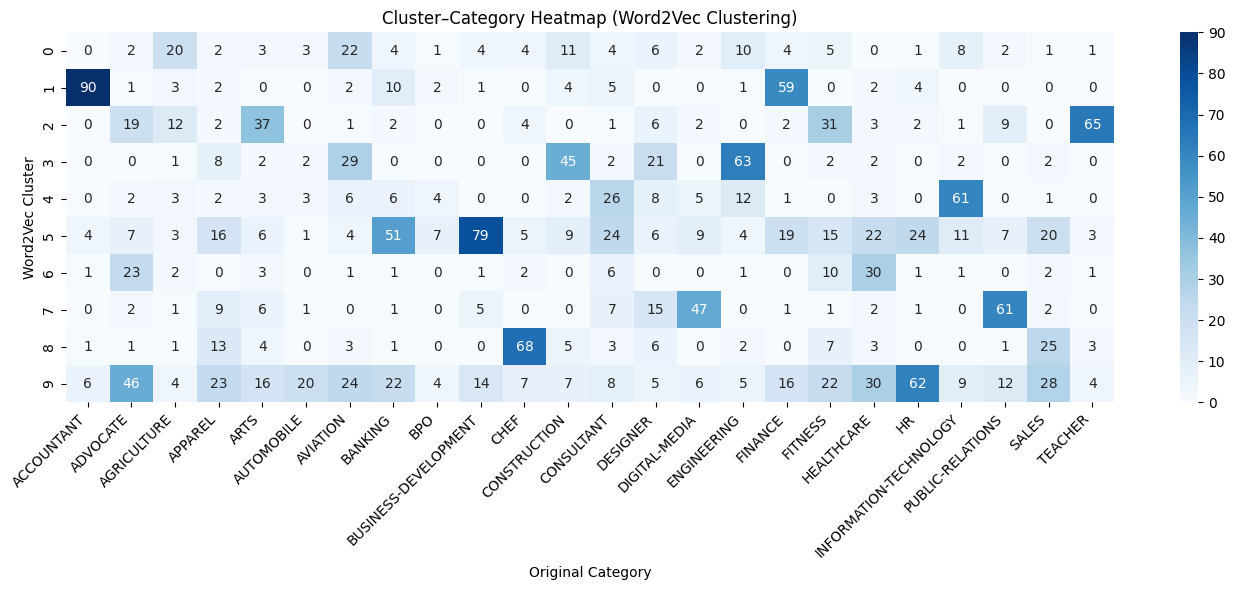

In [37]:
# Word2Vec clusters vs. actual categories
heatmap_data = pd.crosstab(df_resumes['W2V_Cluster'], df_resumes['Category'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')
plt.title('Cluster–Category Heatmap (Word2Vec Clustering)')
plt.xlabel('Original Category')
plt.ylabel('Word2Vec Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ***GloVe***

In [39]:
# average Glove vectors per document
def average_glove_vector(tokens, model):
    valid_words = [w for w in tokens if w in model]
    return np.mean([model[w] for w in valid_words], axis=0) if valid_words else np.zeros(model.vector_size)

#tokenize
df_resumes['tokens'] = df_resumes['clean_str'].apply(lambda x: x.split())
df_jobs['tokens'] = df_jobs['clean_str'].apply(lambda x: x.split())

resume_vecs_glove = np.vstack(df_resumes['tokens'].apply(lambda x: average_glove_vector(x, glove_model)))
job_vecs_glove = np.vstack(df_jobs['tokens'].apply(lambda x: average_glove_vector(x, glove_model)))

# cosine similarity and evaluation
cosine_sim_glove = cosine_similarity(resume_vecs_glove, job_vecs_glove)

def top_k_avg(sim_matrix, k=5):
    return np.mean([np.mean(np.sort(row)[-k:]) for row in sim_matrix])

avg_score_glove = top_k_avg(cosine_sim_glove, k=5)
print(f"Average Top-5 Similarity Score (GloVe): {avg_score_glove:.4f}")



Average Top-5 Similarity Score (GloVe): 0.9847


In [40]:
# KMeans for GloVe resume vectors
kmeans_glove = KMeans(n_clusters=10, random_state=42)
glove_labels = kmeans_glove.fit_predict(resume_vecs_glove)
df_resumes['GloVe_Cluster'] = glove_labels

# silhouette score
glove_silhouette = silhouette_score(resume_vecs_glove, glove_labels)
print(f"Silhouette Score (GloVe Resumes): {glove_silhouette:.4f}")


Silhouette Score (GloVe Resumes): 0.1144


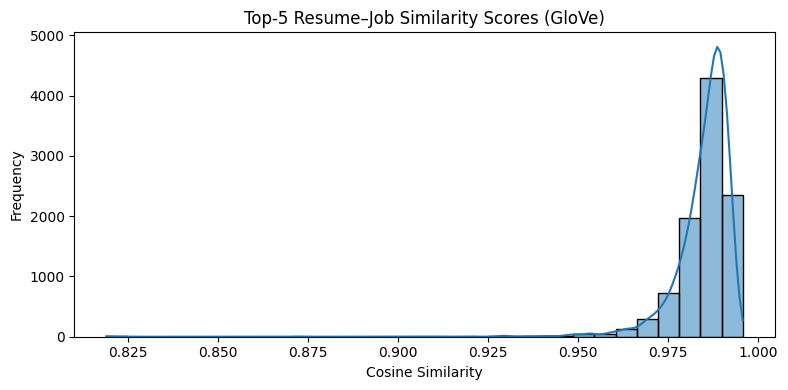

In [41]:
top_k = 5
top_scores = []
for row in cosine_sim_glove:
    top_scores.extend(np.sort(row)[-top_k:])

plt.figure(figsize=(8, 4))
sns.histplot(top_scores, bins=30, kde=True)
plt.title("Top-5 Resume–Job Similarity Scores (GloVe)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

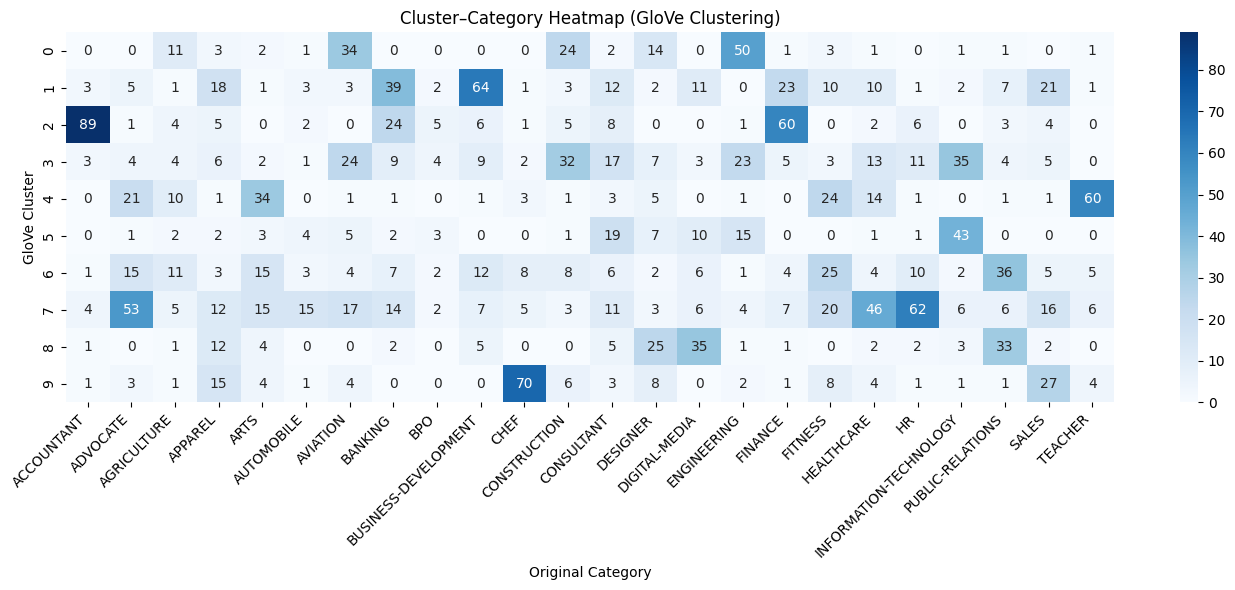

In [42]:
# Cluster–Category Heatmap (GloVe Clustering)
heatmap_data = pd.crosstab(df_resumes['GloVe_Cluster'], df_resumes['Category'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')
plt.title('Cluster–Category Heatmap (GloVe Clustering)')
plt.xlabel('Original Category')
plt.ylabel('GloVe Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Although the silhouette score is low, this heatmap shows that similar categories were grouped together, suggesting the score may not fully reflect the quality of clustering.  The overlap may indicate that some resumes match multiple related job areas, depending on the past experience and skills mentioned on file.

# ***FastText***

Average Top-5 Similarity Score (FastText): 0.9828


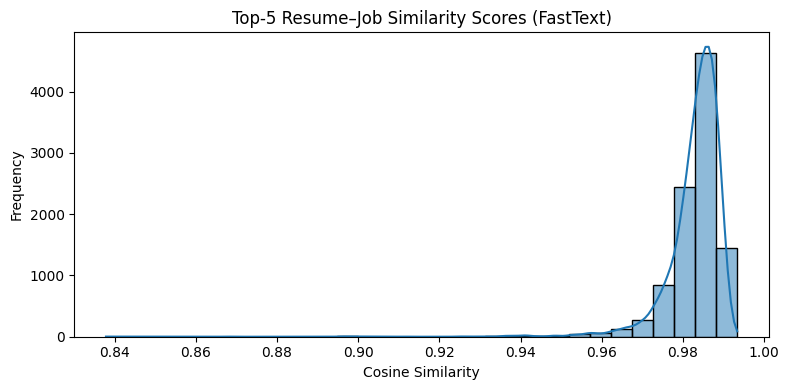

In [44]:
#average FastText vectors
def average_fasttext_vector(tokens, model):
    valid_words = [w for w in tokens if w in model]
    return np.mean([model[w] for w in valid_words], axis=0) if valid_words else np.zeros(model.vector_size)

# document vectors
resume_vecs_fasttext = np.vstack(df_resumes['tokens'].apply(lambda x: average_fasttext_vector(x, fasttext_model)))
job_vecs_fasttext = np.vstack(df_jobs['tokens'].apply(lambda x: average_fasttext_vector(x, fasttext_model)))

# cosine similarity
cosine_sim_fasttext = cosine_similarity(resume_vecs_fasttext, job_vecs_fasttext)

# average top-k score
def top_k_avg(sim_matrix, k=5):
    return np.mean([np.mean(np.sort(row)[-k:]) for row in sim_matrix])

avg_score_fasttext = top_k_avg(cosine_sim_fasttext, k=5)
print(f"Average Top-5 Similarity Score (FastText): {avg_score_fasttext:.4f}")

# score distribution
top_scores = []
for row in cosine_sim_fasttext:
    top_scores.extend(np.sort(row)[-5:])

plt.figure(figsize=(8, 4))
sns.histplot(top_scores, bins=30, kde=True)
plt.title("Top-5 Resume–Job Similarity Scores (FastText)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [45]:
# Clustering
kmeans_fasttext = KMeans(n_clusters=10, random_state=42)
fasttext_labels = kmeans_fasttext.fit_predict(resume_vecs_fasttext)
df_resumes['FastText_Cluster'] = fasttext_labels

# Silhouette score
fasttext_silhouette = silhouette_score(resume_vecs_fasttext, fasttext_labels)
print(f"Silhouette Score (FastText Resumes): {fasttext_silhouette:.4f}")

Silhouette Score (FastText Resumes): 0.0800


# ***BERT***

In [47]:
# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

resume_texts = df_resumes['Resume_str'].fillna('').tolist()
job_texts = df_jobs['description'].fillna('').tolist()

# encoding with BERT
resume_embeddings = model.encode(resume_texts, convert_to_tensor=True)
job_embeddings = model.encode(job_texts, convert_to_tensor=True)

cosine_scores = util.cos_sim(resume_embeddings, job_embeddings)


top_k = 5
top_scores_bert = []

for row in cosine_scores:
    sorted_scores = row.topk(top_k).values
    top_scores_bert.extend(sorted_scores.tolist())

avg_topk_score_bert = np.mean(top_scores_bert)
print(f"\nAverage Top-{top_k} Similarity Score (BERT): {avg_topk_score_bert:.4f}")


Average Top-5 Similarity Score (BERT): 0.6456


In [50]:
def get_top_k_indices(sim_matrix, k=5):
    return [np.argsort(row)[-k:][::-1] for row in sim_matrix]

# top 5 per resume
top5_dict = {
    'TF-IDF': get_top_k_indices(cosine_sim_tfidf),
    'Word2Vec': get_top_k_indices(cosine_sim_w2v),
    'GloVe': get_top_k_indices(cosine_sim_glove),
    'FastText': get_top_k_indices(cosine_sim_fasttext),
    'BERT': [row.topk(5).indices.cpu().numpy() for row in cosine_scores]
}

# Overlap function
def top_k_overlap(list1, list2):
    return np.mean([len(set(a) & set(b)) for a, b in zip(list1, list2)])

# Create matrix
methods = list(top5_dict.keys())
overlap_matrix = pd.DataFrame(index=methods, columns=methods)

for method_a in methods:
    for method_b in methods:
        overlap = top_k_overlap(top5_dict[method_a], top5_dict[method_b])
        overlap_matrix.loc[method_a, method_b] = round(overlap, 2)

print("\nTop-5 Match Overlap Matrix (Average Shared Jobs):")
print(overlap_matrix)



Top-5 Match Overlap Matrix (Average Shared Jobs):
         TF-IDF Word2Vec GloVe FastText  BERT
TF-IDF      5.0      0.5  0.28     0.49  0.26
Word2Vec    0.5      5.0  1.09     1.36  0.24
GloVe      0.28     1.09   5.0     1.48  0.16
FastText   0.49     1.36  1.48      5.0  0.19
BERT       0.26     0.24  0.16     0.19   5.0


Although BERTs similarity scores were lower than other models, it retrieved a different set of job matches with very little overlap. That suggests that it captures meaning in a unique way, varying from the other methods.